In [1]:
import numpy as np
import math

import struct
import os

from tqdm import tqdm

import snntorch as snn
import torch
import torch.nn as nn

import snntorch.spikeplot as splt
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
from torchmetrics.classification import MulticlassConfusionMatrix

from snntorch import surrogate
import snntorch.functional as SF
import torch.nn.functional as F
from torch.nn import NLLLoss, LogSoftmax

from snntorch import spikegen

from sklearn.linear_model import LinearRegression

import matplotlib.pyplot as plt
from matplotlib.colors import SymLogNorm
import snntorch.spikeplot as splt
import imageio

from sklearn.metrics import ConfusionMatrixDisplay

from itertools import accumulate

from collections.abc import Iterable

from copy import deepcopy

device = 'cpu' if torch.backends.mps.is_available() else "cpu"

In [2]:
import visualize
import dataset as ds

In [3]:
device

'cpu'

## Constants

In [4]:
nCublets = 1000
nSensors = 100
max_t = 20
dt = 0.2
timesteps = int(max_t/dt)

In [5]:
labels_map = {
  -1: "unclassified",
   0: "proton",
   1: "kaon",
   2: "pion",
   3: "other"
}
nClasses = len(labels_map)-1

# SNN Classes

## SNN Definition

In [6]:
class Spiking_Net(nn.Module):
    """FCN with variable neural model and number of layers."""

    def __init__(self, net_desc, spikegen_fn):
        super().__init__()
        
        self.n_neurons = net_desc["layers"]
        self.timesteps = net_desc["timesteps"]
        self.output = net_desc["output"]

        modules = []
        for i_layer in range(1, len(self.n_neurons)):
            modules.append(nn.Linear(in_features=self.n_neurons[i_layer-1], out_features=self.n_neurons[i_layer]))
            if "model" in net_desc:
                modules.append(net_desc["model"](**net_desc["neuron_params"][i_layer]))
            else:
                modules.append(net_desc["neuron_params"][i_layer][0](**(net_desc["neuron_params"][i_layer][1])))
        self.network = nn.Sequential(*modules)

        self.spikegen_fn = spikegen_fn

    
    def forward(self, data):
        """Forward pass for several time steps."""

        x = self.spikegen_fn(data)

        # Initalize membrane potential
        mem = []
        for i, module in enumerate(self.network):
            if i%2==1:
                res = module.reset_mem()
                if type(res) is tuple:
                    mem.append(list(res))
                else:
                    mem.append([res])

        # Record the final layer
        spk_rec = []
        mem_rec = []

        # Loop over 
        spk = None
        for step in range(self.timesteps):
            for i_layer in range(len(self.network)//2):
                if i_layer == 0:
                    cur = self.network[2*i_layer](x[step])
                else:
                    cur = self.network[2*i_layer](spk)
                
                spk, *(mem[i_layer]) = self.network[2*i_layer+1](cur, *(mem[i_layer]))

                if i_layer == len(self.network)//2-1:
                    spk_rec.append(spk)
                    mem_rec.append(mem[i_layer][-1])

        if self.output == "spike":
            return torch.stack(spk_rec, dim=0)
        elif self.output == "membrane":
            return torch.stack(mem_rec, dim=0)

## Predictor Class 
To compare NN output with targets

In [7]:
def predict_membrane(output):
    prediction = output[-1].squeeze(1)
    if len(prediction.shape) > 1:
        prediction = prediction.mean(1)
    return prediction

def predict_spikefreq(output):
    prediction = output.sum(0).mean(1) # sum spikes across time and average over the population
    return prediction

class Predictor():

    def __init__(self, predict, transform=None, relative=True, population_sizes=None):
        self.predict = predict
        self.transform = transform
        self.relative = relative
        self.population_sizes = population_sizes

    def _predict_singletask(self, output, targets):
        prediction = self.predict(output)
        if self.transform:
            prediction, targets = self.transform(prediction), self.transform(targets)
        accuracy = torch.abs(targets - prediction)
        if self.relative:
            accuracy /= targets
        return prediction, torch.mean(accuracy, 0)
    
    def __call__(self, output, targets):
        #check if multiple task must be handled
        if len(targets.shape) == 1:
            return self._predict_singletask(output, targets)
        
        # populations of different size
        if isinstance(self.population_sizes, (list, np.ndarray)):
            if sum(self.population_sizes) != output.shape[-1]:
                raise ValueError("Population sizes must add up to last layer size!")
            if len(self.population_sizes) != targets.shape[-1]:
                raise ValueError("Number of populations must be equal to number of tasks!")
            prediction = torch.zeros(size=targets.shape)
            accuracy = torch.zeros(size=(targets.shape[1],))
            chunks = list(accumulate([0]+list(self.population_sizes)))
            for i, pop in enumerate(self.population_sizes):
                prediction[:, i], accuracy[i] = \
                        self._predict_singletask(output[chunks[i]:chunks[i+1]], targets[:, i])
            return  prediction, accuracy          

        # populations of the same size
        if isinstance(self.population_sizes, int):
            output = output.reshape(output.shape[0], output.shape[1], self.population_sizes, -1)
            if output.shape[-1] != targets.shape[-1]:
                raise ValueError("Number of populations must be equal to number of tasks!")
        return self._predict_singletask(output, targets)

## Trainer Class
For training and testing on datasets

In [8]:
class Trainer():

    def __init__(self, net, loss_fn, optimizer, predict,
                 train_dataset, val_dataset, test_dataset, task="Regression", scheduler= None):
        self.net = net
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.predict = predict 
        self.scheduler = scheduler   
        self.datasets = {"train": train_dataset, "validation": val_dataset, "test": test_dataset}
        self.task = task

        self.current_epoch = 0
        self.loss_hist = {"train": {}, "validation": {}, "test": {}}
        self.acc_hist = {"validation": {}, "test": {}}


    def test(self, dataset_name):
        
        # by default, computes accuracy on test dataset
        try:
            if dataset_name == "validation" or dataset_name == "test":
                dataset = self.datasets[dataset_name]
            else:
                raise NameError("Unidentified dataset name. Please choose between \"validation\" or \"test\".")
        except NameError as n:
            print(f"Error: {n}")

        temp_loss = []
        temp_acc = []

        self.net.eval()
        with torch.no_grad():
            temp_loss = []
            for data, targets in dataset:
                data = data.to(device)
                targets = targets.to(device)

                # forward pass
                output = self.net(data)
                pred, acc = self.predict(output, targets)

                # compute loss
                loss = self.loss_fn(pred, targets)
                temp_loss.append(loss.item())
                temp_acc.append(acc.tolist())

        self.loss_hist[dataset_name][self.current_epoch] = np.mean(temp_loss, axis=0)
        self.acc_hist[dataset_name][self.current_epoch] = np.mean(np.array(temp_acc), axis=0)


    def train(self, num_epochs, verbosity=1):

        self.net.to(device)

        # Validation
        self.test("validation")
        if verbosity:
            task_metric = "Average Error" if self.task == "Regression" else "Accuracy"
            print(f"Epoch {self.current_epoch}:")
            print(f"Validation Loss = {self.loss_hist['validation'][self.current_epoch]}")
            print(f"Validation {task_metric} = {self.acc_hist['validation'][self.current_epoch]}")
            print("\n-------------------------------\n")

        for epoch in tqdm(range(num_epochs), desc="Epoch"):
            self.net.train()
            # Minibatch training loop
            for data, targets in tqdm(self.datasets["train"], desc="Batches", leave=False):
                data = data.to(device)
                targets = targets.to(device)

                # forward pass
                output = self.net(data)
                pred, _ = self.predict(output, targets)

                # compute loss
                loss_val = self.loss_fn(pred, targets)

                # Gradient calculation + weight update
                self.optimizer.zero_grad()
                loss_val.backward()
                self.optimizer.step()
                if self.scheduler is not None:
                    self.scheduler.step()

                # Store loss history for future plotting
                if self.current_epoch in self.loss_hist["train"]:
                    self.loss_hist["train"][self.current_epoch].append(loss_val.item())
                else:
                    self.loss_hist["train"][self.current_epoch] = [loss_val.item()]

            self.current_epoch += 1

            # Validation
            self.test("validation")

            if verbosity:
                print(f"Epoch {self.current_epoch}:")
                print(f"Validation Loss = {self.loss_hist['validation'][self.current_epoch]}")
                print(f"Validation {task_metric} = {self.acc_hist['validation'][self.current_epoch]}")
                print("\n-------------------------------\n")

    
    def plot_loss(self, validation=True, logscale=True):

        loss = [l for l_per_epoch in self.loss_hist["train"].values() for l in l_per_epoch]
        fig = plt.figure(facecolor="w", figsize=(4, 3))
        plt.xlabel("Iteration")
        plt.ylabel("Loss")
        if logscale:
            plt.yscale("log")
        plt.plot(loss, label="Training")
        if validation:
            x = [i*len(self.datasets["train"]) for i in self.loss_hist["validation"]]
            plt.plot(x, list(self.loss_hist["validation"].values()), color='orange', marker='o', linestyle='dashed', label="Validation")
        
        plt.legend(loc='upper right')
        plt.show()

    
    def ConfusionMatrix(self, *args, **kwargs):

        cm = MulticlassConfusionMatrix(*args, **kwargs)

        self.net.eval()
        with torch.no_grad():
            for data, targets in self.datasets["test"]:
                data = data.to(device)
                targets = targets.to(device)

                # forward pass
                output = self.net(data)

                # calculate total accuracy
                pred, acc = self.predict(output, targets)
                cm.update(pred, targets)
        
        return cm
    

    def plot_pred_vs_target(self, nbins=50, title="", logscale=False, select=None, *args, **kwargs):

        self.net.eval()
        all_targets = []
        all_predictions = []
        with torch.no_grad():
            for data, targets in self.datasets["test"]:
                data = data.to(device)
                targets = targets.to(device)

                # forward pass
                output = self.net(data)

                # calculate total accuracy
                pred, _ = self.predict(output, targets)

                if self.predict.transform:
                    targets = self.predict.transform(targets)
                all_targets.append(targets)
                all_predictions.append(pred)

        all_targets = torch.cat(all_targets, dim=0).numpy()
        all_predictions = torch.cat(all_predictions, dim=0).numpy()

        if len(all_targets.shape) < 2:
            all_targets = all_targets.unsqueeze(-1)
            all_predictions = all_predictions.unsqueeze(-1)
        n_tasks = all_targets.shape[-1]
        if select is not None:
            n_tasks = min(n_tasks, len(select))
        else:
            select = [i for i in range(n_tasks)]
            
        ncols = math.ceil(math.sqrt(n_tasks))
        nrows = math.ceil(n_tasks / ncols)
        
        fig, axs = plt.subplots(ncols=ncols, nrows=nrows, facecolor="w", figsize=(5*ncols, 4*nrows), constrained_layout=True)
        if not isinstance(axs, np.ndarray):
            axs = np.array([axs])
            title = [title]

        axs = axs.flatten()
        for i in range(n_tasks):
            axs[i].set_xlabel("Targets")
            axs[i].set_ylabel("Prediction")
            axs[i].set_title(title[i])
            if logscale:
                hist = axs[i].hist2d(all_targets[:, select[i]], all_predictions[:, select[i]],
                                     nbins, norm=SymLogNorm(*args, **kwargs), cmap='viridis')
            else:
                hist = axs[i].hist2d(all_targets[:, select[i]], all_predictions[:, select[i]], nbins, cmap='viridis')

            axs[i].plot([0, 1e5], [0, 1e5], color='white', linewidth=1, linestyle='--')
        for i in range(n_tasks, len(axs)):
            fig.delaxes(axs[i])

        # Add a color bar
        if hist:
            cbar = fig.colorbar(hist[3], ax=axs, orientation='vertical', fraction=0.02, pad=0.04)
            cbar.set_label("Counts")  # Customize as needed
            
        plt.show()

        fig, axs = plt.subplots(ncols=ncols, nrows=nrows, facecolor="w", figsize=(5*ncols, 4*nrows), constrained_layout=True)
        if not isinstance(axs, np.ndarray):
            axs = np.array([axs])
            title = [title]

        axs = axs.flatten()
        for i in range(n_tasks):
            axs[i].set_ylabel("Counts")
            axs[i].set_xlabel("Residuals")
            axs[i].set_title(title[i])
            axs[i].grid(True, linestyle='--', alpha=0.6)
            axs[i].axvline(0, color='black', linewidth=1, linestyle='--', alpha=0.5)
            axs[i].spines['top'].set_visible(False)
            axs[i].spines['right'].set_visible(False)
            if logscale:
                axs[i].set_yscale('log')

            hist = axs[i].hist((all_targets[:, select[i]] - all_predictions[:, select[i]]), nbins, edgecolor='black', alpha=0.7)
            
        for i in range(n_tasks, len(axs)):
            fig.delaxes(axs[i])

        plt.show()


    def show_results(self, only_errors=False, *args, **kwargs):
        if only_errors:
            return self.acc_hist['test'][self.current_epoch].mean()
        else:
            print(f"Test loss: {self.loss_hist['test'][self.current_epoch]}")
            print(f"Test relative error: {self.acc_hist['test'][self.current_epoch]*100}%")
            self.plot_loss()
            self.plot_pred_vs_target(*args, **kwargs)
        


## Network Descriptions and Spike Encodings

In [9]:
# Network Descriptions

population = 80

net_desc = {
    "layers" : [400, 50, population],
    "timesteps": 100,
    "neuron_params" : {
                1: [snn.Leaky, 
                    {"beta" : 1.0,
                    "learn_beta": True,
                    "threshold" : 1.0,
                    "learn_threshold": False,
                    "spike_grad": surrogate.atan(),
                    }],
                2: [snn.Leaky, 
                    {"beta" : 1.0,
                    "learn_beta": True,
                    "threshold" : 1.0,
                    "learn_threshold": False,
                    "spike_grad": surrogate.atan(),
                    }],
                3: [snn.Leaky, 
                    {"beta" : 1.0,
                    "learn_beta": True,
                    "threshold" : 1.0e20,
                    "learn_threshold": False, 
                    "spike_grad": surrogate.atan(),
                    }]
                }
    }

net_desc_membrane = deepcopy(net_desc)
net_desc_membrane["output"] = "membrane"

net_desc_spikefreq = deepcopy(net_desc)
net_desc_spikefreq["output"] = "spike"
net_desc_spikefreq["neuron_params"][len(net_desc['neuron_params'])][1]["threshold"] = 1.0
net_desc_spikefreq["neuron_params"][len(net_desc['neuron_params'])][1]["learn_threshold"] = True


# Spike Generation

def _spikegen(data):
    spike_data = data.transpose(0,1) 
    spike_train = torch.where(spike_data > 300, torch.tensor(1), torch.tensor(0)).to(torch.float32) 
    return spike_train

def spikegen_multi(data, multiplicity=4):
    og_shape = data.shape
    spike_data = torch.zeros(og_shape[1], og_shape[0], multiplicity*og_shape[2])
    for i in range(multiplicity):
        condition = data > np.power(10, i+2)
        batch_idx, time_idx, sensor_idx = torch.nonzero(condition, as_tuple=True)
        spike_data[time_idx, batch_idx, multiplicity*sensor_idx+i] = 1

    return spike_data

## Loss Functions

In [10]:
class multi_MSELoss(torch.nn.Module):

    def __init__(self, reduction: str = "mean", weights : torch.tensor = torch.ones(1),) -> None:
        super(multi_MSELoss, self).__init__()
        self.reduction = reduction
        self.weights = weights

    def forward(self, input: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
        
        if len(target.shape) < 2:
            target = target.unsqueeze(-1)

        losses = torch.zeros(target.shape[-1])
        for i in range(target.shape[-1]):
            if i == 0 or i == 3:
                losses[i] = F.l1_loss(input[:, i], target[:, i], reduction=self.reduction)
            else:
                losses[i] = F.mse_loss(input[:, i], target[:, i], reduction=self.reduction)
        
        return (self.weights*losses).sum()

## Dataset Creation

In [45]:
dataset = ds.build_dataset("../Data/PrimaryOnly/Uniform/", max_files=100, primary_only=True,
                           target=["energy","centroid","dispersion"])

# Energy and Position

In [46]:
dataset.transform = lambda x: (x[0], ds.to_tensor_and_dtype([np.log10(x[1][0]), *x[1][1]], torch.float32))
train_dataset, test_dataset, val_dataset = ds.build_loaders(dataset, (0.7, 0.15), shuffle=True, num_workers=0)

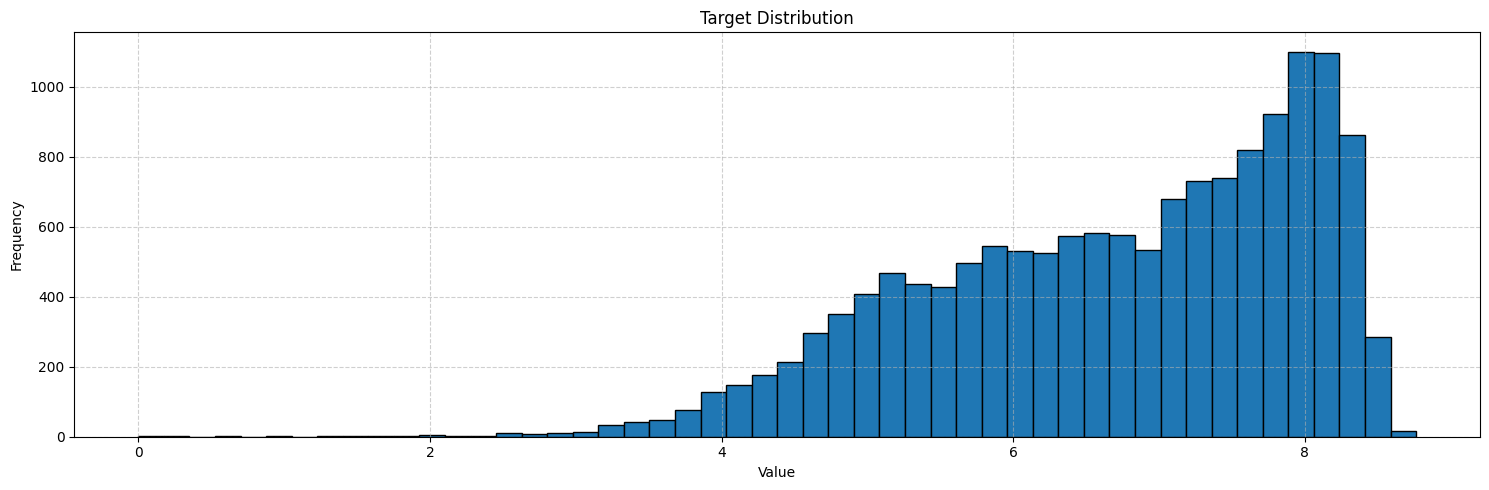

In [47]:
# Extract targets from the train_dataset
targets = []
for data in dataset:
    targets.append(data[1][3])

# Plot the distributions
fig = plt.figure(figsize=(15, 5))
plt.hist(targets, bins=50, edgecolor='black')
plt.title(f'Target Distribution')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

In [48]:
def build_network(params_values):
    population = 80
    for row in params_values:
        net_desc = {}
        l,N = row[0], row[1]
        net_desc["layers"] = [400] + [N for i in range(l)] + [population]
        net_desc['timesteps'] = 100
        net_desc["neuron_params"] = {i:  [snn.Leaky, 
                        {"beta" : 1.0,
                        "learn_beta": True,
                        "threshold" : 1.0,
                        "learn_threshold": True,
                        "spike_grad": surrogate.atan(),
                        }] for i in range(1, l+2)}
        net_desc["output"] = "spike"
    return net_desc

net_desc_spikefreq = build_network(np.array([[2, 120]]))

In [49]:
trials = 5
num_epochs = 10
low_err = 1E3
best_model = None
errors = []

for i in range(trials):
    net_Epos_spk = Spiking_Net(net_desc_spikefreq, lambda x: spikegen_multi(x,4))
    Pred_Epos_spk = Predictor(predict_spikefreq, population_sizes=int(population/4))
    loss_Epos = multi_MSELoss(weights=torch.tensor([1,1,1,1]))
    opt_Epos_spk = torch.optim.Adam(net_Epos_spk.parameters(), lr=1e-3, betas=(0.9, 0.999), weight_decay=1e-3)
    sche_Epos_spk = torch.optim.lr_scheduler.ExponentialLR(opt_Epos_spk, gamma=0.8)
    train_Epos_spk = Trainer(net_Epos_spk, loss_Epos, opt_Epos_spk, Pred_Epos_spk,
                    train_dataset, val_dataset, test_dataset,sche_Epos_spk)
    
    train_Epos_spk.train(num_epochs)
    
    train_Epos_spk.test("test")
    test_err = train_Epos_spk.show_results( only_errors = True )

    errors.append(test_err)
    if test_err < low_err:
        low_err = test_err
        best_model = deepcopy(train_Epos_spk)

Epoch 0:
Validation Loss = 29.2759400261773
Validation Accuracy = [0.24641038 0.649448   0.61974845 0.86855906]

-------------------------------



Epoch:  10%|█         | 1/10 [00:22<03:20, 22.27s/it]

Epoch 1:
Validation Loss = 2.70667351881663
Validation Accuracy = [0.03092495 0.25818137 0.5054926  0.06239136]

-------------------------------



Epoch:  20%|██        | 2/10 [00:43<02:53, 21.66s/it]

Epoch 2:
Validation Loss = 1.8741523027420044
Validation Accuracy = [0.02980218 0.21940842 0.34910238 0.06023242]

-------------------------------



Epoch:  30%|███       | 3/10 [01:05<02:32, 21.77s/it]

Epoch 3:
Validation Loss = 1.7974641455544367
Validation Accuracy = [0.03002006 0.19485981 0.38172188 0.05533362]

-------------------------------



Epoch:  40%|████      | 4/10 [01:26<02:09, 21.56s/it]

Epoch 4:
Validation Loss = 1.8922210110558404
Validation Accuracy = [0.02476364 0.16702993 0.28494126 0.05914446]

-------------------------------



Epoch:  50%|█████     | 5/10 [01:48<01:48, 21.66s/it]

Epoch 5:
Validation Loss = 1.5373029708862305
Validation Accuracy = [0.0285325  0.15019078 0.27477889 0.04165037]

-------------------------------



Epoch:  60%|██████    | 6/10 [02:09<01:26, 21.58s/it]

Epoch 6:
Validation Loss = 1.3046722571055094
Validation Accuracy = [0.02086593 0.15587717 0.26927301 0.04683602]

-------------------------------



Epoch:  70%|███████   | 7/10 [02:31<01:04, 21.63s/it]

Epoch 7:
Validation Loss = 1.3885861926608616
Validation Accuracy = [0.02357696 0.15070201 0.25473897 0.04343383]

-------------------------------



Epoch:  80%|████████  | 8/10 [02:53<00:43, 21.66s/it]

Epoch 8:
Validation Loss = 1.201214337348938
Validation Accuracy = [0.0218885  0.14744816 0.26153227 0.04690861]

-------------------------------



Epoch:  90%|█████████ | 9/10 [03:14<00:21, 21.60s/it]

Epoch 9:
Validation Loss = 1.1269534720314873
Validation Accuracy = [0.02576667 0.13861268 0.23928332 0.03523275]

-------------------------------



Epoch: 100%|██████████| 10/10 [03:36<00:00, 21.66s/it]

Epoch 10:
Validation Loss = 1.324738824367523
Validation Accuracy = [0.05045374 0.14669716 0.22524379 0.04825169]

-------------------------------



Epoch 0:
Validation Loss = 24.874764675564236
Validation Accuracy = [0.43006624 0.68486727 0.63970184 0.8391675 ]

-------------------------------



Epoch:  10%|█         | 1/10 [00:20<03:07, 20.85s/it]

Epoch 1:
Validation Loss = 2.2514739486906263
Validation Accuracy = [0.03689469 0.24731149 0.37906849 0.06369438]

-------------------------------



Epoch:  20%|██        | 2/10 [00:41<02:47, 20.98s/it]

Epoch 2:
Validation Loss = 1.6401574903064304
Validation Accuracy = [0.02662224 0.20614126 0.33820433 0.04967067]

-------------------------------



Epoch:  30%|███       | 3/10 [01:02<02:25, 20.83s/it]

Epoch 3:
Validation Loss = 1.535366612010532
Validation Accuracy = [0.03853941 0.17222434 0.30066253 0.04668317]

-------------------------------



Epoch:  40%|████      | 4/10 [01:22<02:03, 20.64s/it]

Epoch 4:
Validation Loss = 1.4487544722027248
Validation Accuracy = [0.04387549 0.15684819 0.27053598 0.04188389]

-------------------------------



Epoch:  50%|█████     | 5/10 [01:42<01:41, 20.29s/it]

Epoch 5:
Validation Loss = 1.6983844068315295
Validation Accuracy = [0.02325477 0.16956745 0.32947351 0.04936962]

-------------------------------



Epoch:  60%|██████    | 6/10 [02:02<01:20, 20.09s/it]

Epoch 6:
Validation Loss = 1.255274642838372
Validation Accuracy = [0.02701173 0.14632527 0.26788504 0.04511699]

-------------------------------



Epoch:  70%|███████   | 7/10 [02:22<01:00, 20.26s/it]

Epoch 7:
Validation Loss = 1.382888252205319
Validation Accuracy = [0.03101628 0.1520661  0.28954804 0.0426773 ]

-------------------------------



Epoch:  80%|████████  | 8/10 [02:43<00:40, 20.33s/it]

Epoch 8:
Validation Loss = 1.1795136425230237
Validation Accuracy = [0.02354915 0.15379638 0.26659684 0.04023314]

-------------------------------



Epoch:  90%|█████████ | 9/10 [03:03<00:20, 20.35s/it]

Epoch 9:
Validation Loss = 1.2967066552903916
Validation Accuracy = [0.02664264 0.15745893 0.29316178 0.04098258]

-------------------------------



Epoch: 100%|██████████| 10/10 [03:24<00:00, 20.45s/it]

Epoch 10:
Validation Loss = 1.3525139914618598
Validation Accuracy = [0.02165497 0.138237   0.23984551 0.04848601]

-------------------------------



Epoch 0:
Validation Loss = 26.057301796807185
Validation Accuracy = [0.45136236 0.64273832 0.65668524 0.73221166]

-------------------------------



Epoch:  10%|█         | 1/10 [00:20<03:05, 20.56s/it]

Epoch 1:
Validation Loss = 2.8176218880547417
Validation Accuracy = [0.03952719 0.23977395 0.38369636 0.07111549]

-------------------------------



Epoch:  20%|██        | 2/10 [00:40<02:43, 20.44s/it]

Epoch 2:
Validation Loss = 1.642834382587009
Validation Accuracy = [0.02935656 0.20265858 0.30925738 0.05168506]

-------------------------------



Epoch:  30%|███       | 3/10 [01:01<02:23, 20.54s/it]

Epoch 3:
Validation Loss = 1.4751821862326728
Validation Accuracy = [0.02892713 0.18737922 0.28281919 0.04956818]

-------------------------------



Epoch:  40%|████      | 4/10 [01:21<02:02, 20.47s/it]

Epoch 4:
Validation Loss = 1.659574908680386
Validation Accuracy = [0.02376638 0.16839906 0.30370133 0.04267244]

-------------------------------



Epoch:  50%|█████     | 5/10 [01:42<01:42, 20.50s/it]

Epoch 5:
Validation Loss = 1.2479518850644429
Validation Accuracy = [0.02257436 0.14685435 0.28704616 0.04096646]

-------------------------------



Epoch:  60%|██████    | 6/10 [02:02<01:21, 20.48s/it]

Epoch 6:
Validation Loss = 1.226920771598816
Validation Accuracy = [0.02585695 0.14707519 0.2639598  0.04231091]

-------------------------------



Epoch:  70%|███████   | 7/10 [02:22<01:01, 20.34s/it]

Epoch 7:
Validation Loss = 1.1787087877591451
Validation Accuracy = [0.02476493 0.14439559 0.25718274 0.04389223]

-------------------------------



Epoch:  80%|████████  | 8/10 [02:43<00:40, 20.39s/it]

Epoch 8:
Validation Loss = 1.14837310579088
Validation Accuracy = [0.02446451 0.13769453 0.2367438  0.0416008 ]

-------------------------------



Epoch:  90%|█████████ | 9/10 [03:03<00:20, 20.35s/it]

Epoch 9:
Validation Loss = 1.0714050783051385
Validation Accuracy = [0.0250908  0.1451889  0.23323672 0.03680823]

-------------------------------



Epoch: 100%|██████████| 10/10 [03:24<00:00, 20.43s/it]

Epoch 10:
Validation Loss = 1.0698287394311694
Validation Accuracy = [0.01992925 0.1456764  0.26312513 0.03433792]

-------------------------------



Epoch 0:
Validation Loss = 28.821006096733942
Validation Accuracy = [0.39740765 0.63418381 0.61895641 0.42728958]

-------------------------------



Epoch:  10%|█         | 1/10 [00:20<03:07, 20.86s/it]

Epoch 1:
Validation Loss = 2.2897484329011704
Validation Accuracy = [0.02822478 0.23776897 0.40124687 0.06699941]

-------------------------------



Epoch:  20%|██        | 2/10 [00:41<02:46, 20.81s/it]

Epoch 2:
Validation Loss = 1.592433672481113
Validation Accuracy = [0.02685949 0.19843601 0.32608597 0.04680424]

-------------------------------



Epoch:  30%|███       | 3/10 [01:02<02:24, 20.70s/it]

Epoch 3:
Validation Loss = 1.3650797141922846
Validation Accuracy = [0.02257928 0.16402041 0.2811565  0.04751023]

-------------------------------



Epoch:  40%|████      | 4/10 [01:22<02:03, 20.60s/it]

Epoch 4:
Validation Loss = 1.367620595296224
Validation Accuracy = [0.02106288 0.17129762 0.29228097 0.04969931]

-------------------------------



Epoch:  50%|█████     | 5/10 [01:43<01:42, 20.59s/it]

Epoch 5:
Validation Loss = 1.875757344563802
Validation Accuracy = [0.03299605 0.18559713 0.3143516  0.04643112]

-------------------------------



Epoch:  60%|██████    | 6/10 [02:03<01:22, 20.63s/it]

Epoch 6:
Validation Loss = 1.3646522257063123
Validation Accuracy = [0.02469684 0.15031316 0.29104232 0.05143245]

-------------------------------



Epoch:  70%|███████   | 7/10 [02:24<01:01, 20.57s/it]

Epoch 7:
Validation Loss = 1.1549591382344564
Validation Accuracy = [0.01949286 0.14600936 0.27670206 0.03939025]

-------------------------------



Epoch:  80%|████████  | 8/10 [02:44<00:41, 20.54s/it]

Epoch 8:
Validation Loss = 1.1413744767506917
Validation Accuracy = [0.02766597 0.1449307  0.23922751 0.04292994]

-------------------------------



Epoch:  90%|█████████ | 9/10 [03:05<00:20, 20.51s/it]

Epoch 9:
Validation Loss = 1.2983642710579766
Validation Accuracy = [0.01958878 0.15438708 0.34027071 0.03751677]

-------------------------------



Epoch: 100%|██████████| 10/10 [03:25<00:00, 20.59s/it]

Epoch 10:
Validation Loss = 1.0872980939017403
Validation Accuracy = [0.02039836 0.14424765 0.21178615 0.0407256 ]

-------------------------------



Epoch 0:
Validation Loss = 24.981174511379667
Validation Accuracy = [0.46766517 0.65088158 0.65224969 0.67401294]

-------------------------------



Epoch:  10%|█         | 1/10 [00:20<03:06, 20.75s/it]

Epoch 1:
Validation Loss = 2.708880384763082
Validation Accuracy = [0.02914871 0.25835243 0.38266883 0.07143658]

-------------------------------



Epoch:  20%|██        | 2/10 [00:41<02:45, 20.63s/it]

Epoch 2:
Validation Loss = 1.6908957322438558
Validation Accuracy = [0.02608053 0.19223231 0.31662007 0.04986323]

-------------------------------



Epoch:  30%|███       | 3/10 [01:01<02:23, 20.54s/it]

Epoch 3:
Validation Loss = 1.5391870313220555
Validation Accuracy = [0.02448534 0.16809734 0.292081   0.0432992 ]

-------------------------------



Epoch:  40%|████      | 4/10 [01:22<02:03, 20.63s/it]

Epoch 4:
Validation Loss = 1.4661695983674792
Validation Accuracy = [0.02702999 0.16267688 0.30761504 0.04381666]

-------------------------------



Epoch:  50%|█████     | 5/10 [01:43<01:43, 20.61s/it]

Epoch 5:
Validation Loss = 1.3822682711813186
Validation Accuracy = [0.0212798  0.16384953 0.28806006 0.04707255]

-------------------------------



Epoch:  60%|██████    | 6/10 [02:03<01:22, 20.53s/it]

Epoch 6:
Validation Loss = 1.5706915299097697
Validation Accuracy = [0.02371716 0.16943606 0.26587443 0.03786516]

-------------------------------



Epoch:  70%|███████   | 7/10 [02:23<01:01, 20.47s/it]

Epoch 7:
Validation Loss = 1.3988725026448567
Validation Accuracy = [0.02050565 0.17870896 0.25686006 0.03739609]

-------------------------------



Epoch:  80%|████████  | 8/10 [02:44<00:40, 20.44s/it]

Epoch 8:
Validation Loss = 1.2640602509180705
Validation Accuracy = [0.03287434 0.14160765 0.25943928 0.04343073]

-------------------------------



Epoch:  90%|█████████ | 9/10 [03:04<00:20, 20.39s/it]

Epoch 9:
Validation Loss = 1.0760567956500584
Validation Accuracy = [0.02060217 0.15540091 0.2449097  0.03740842]

-------------------------------



Epoch: 100%|██████████| 10/10 [03:24<00:00, 20.49s/it]

Epoch 10:
Validation Loss = 1.3367140730222067
Validation Accuracy = [0.02096567 0.1540505  0.3443896  0.0356931 ]

-------------------------------



Test loss: 1.1062606255213419
Test relative error: [ 2.11071534 18.31950787 19.41989649  3.92365843]%


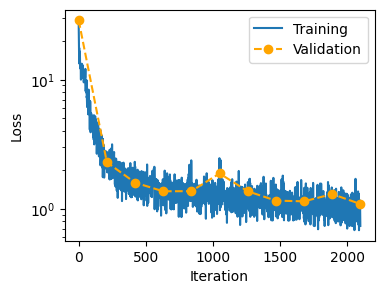

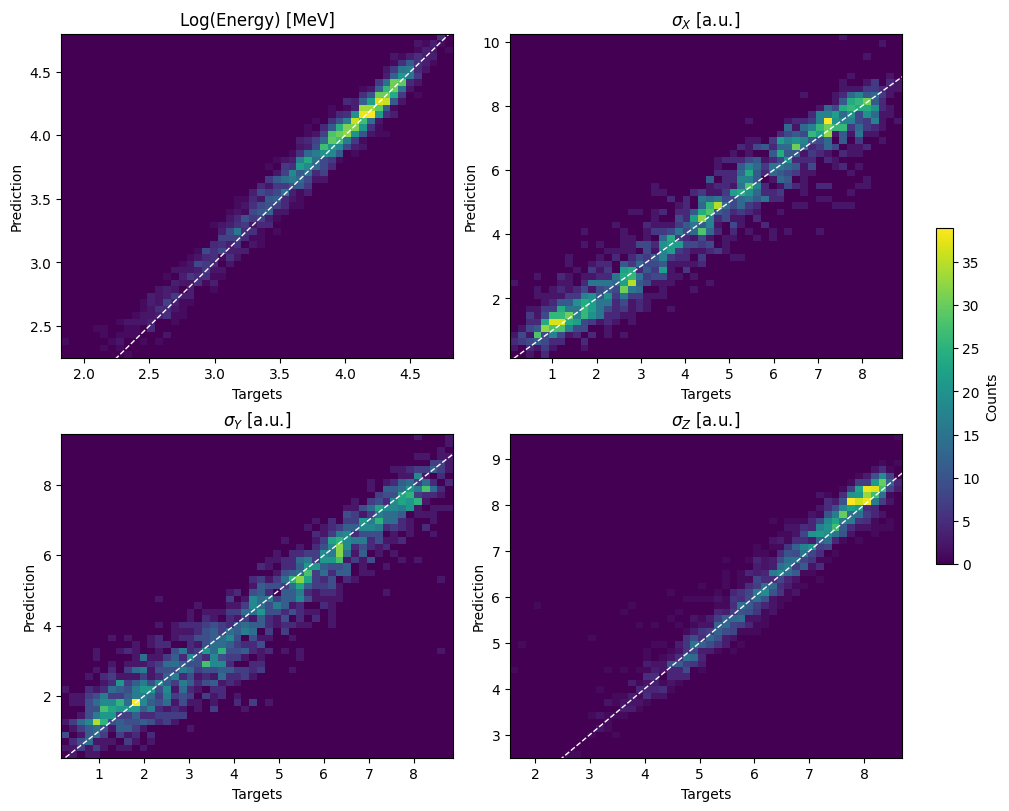

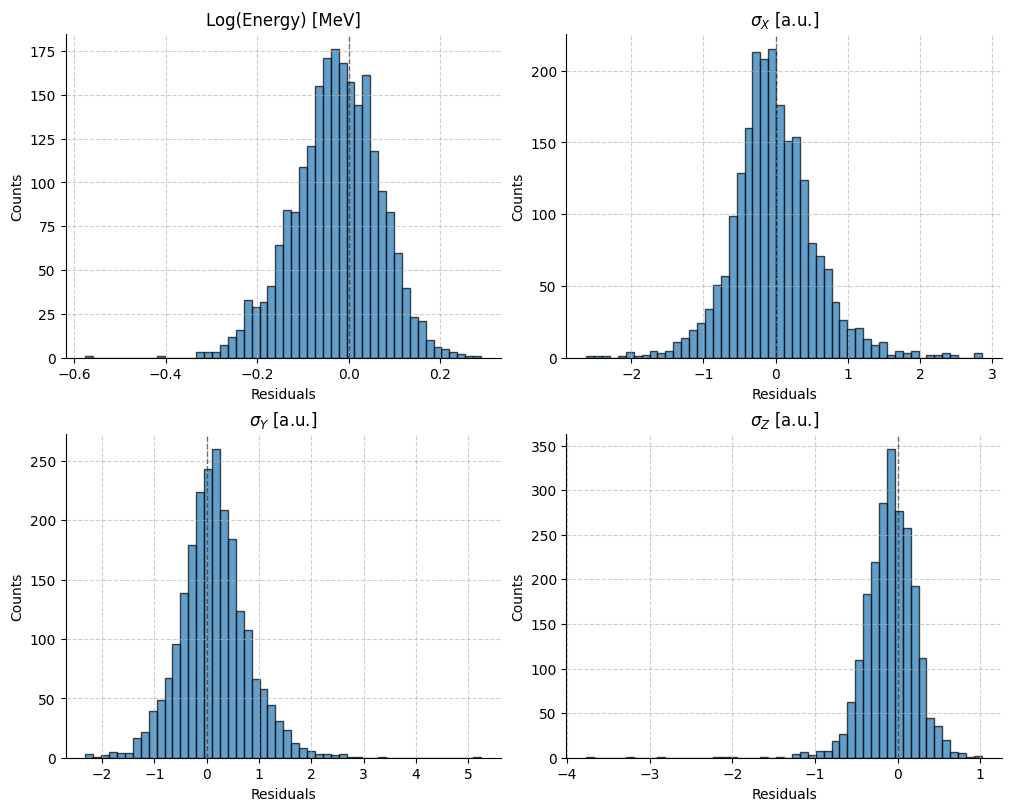

In [50]:
best_model.test("test")
best_model.show_results( only_errors=False, nbins=50, title=["Log(Energy) [MeV]", "$\sigma_X$ [a.u.]", "$\sigma_Y$ [a.u.]", "$\sigma_Z$ [a.u.]"],  logscale=False)

In [51]:
best_model.predict.relative = False
best_model.test("test")
print(f"Test absolute error: {best_model.acc_hist['test'][best_model.current_epoch]}")

Test absolute error: [0.07605391 0.43618461 0.49945628 0.23690669]


In [52]:
best_model.predict.transform = None

Test loss: 11304.417447916667
Test relative error: [19.11029021 18.33217705 19.42160904  3.91975169]%


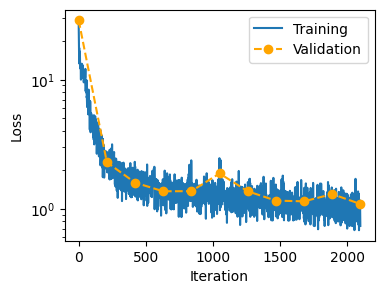

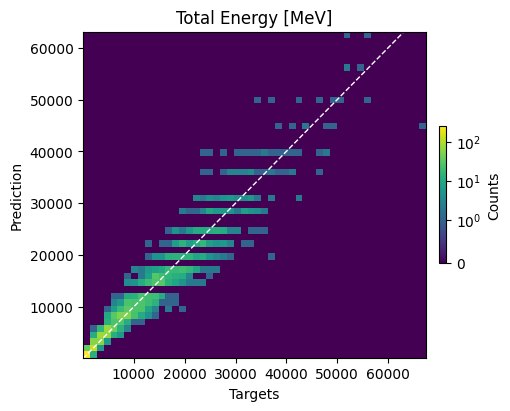

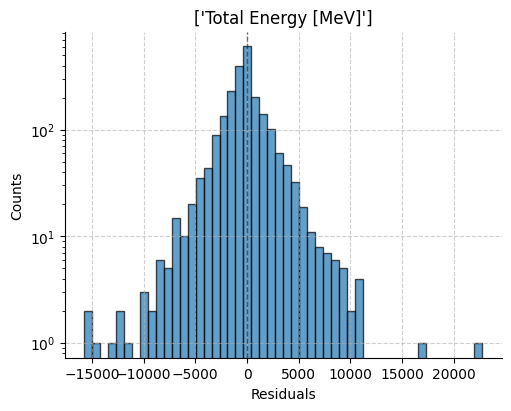

In [53]:
def antitransform(x):
    a = x.clone() 
    a[:, 0] = torch.pow(10, a[:,0])
    return a
best_model.predict.transform = antitransform
best_model.predict.relative = True

best_model.test("test")
best_model.show_results(nbins=50, logscale=True, linthresh=1, title="Total Energy [MeV]", select=[0])

In [54]:
best_model.predict.relative = False
best_model.test("test")
print(f"Test absolute error: {best_model.acc_hist['test'][best_model.current_epoch]}")

Test absolute error: [1.65538813e+03 4.36105096e-01 5.00114481e-01 2.37162427e-01]


## Network Archit Optim

In [20]:
from scipy.stats import norm
from scipy.optimize import minimize
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, DotProduct

def expected_improvement(X, X_sample, Y_sample, gpr, xi=0.75):
    '''
    Computes the EI at points X based on existing samples X_sample
    and Y_sample using a Gaussian process surrogate model.
    
    Args:
        X: Points at which EI shall be computed (m x d).
        X_sample: Sample locations (n x d).
        Y_sample: Sample values (n x 1).
        gpr: A GaussianProcessRegressor fitted to samples.
        xi: Exploitation-exploration trade-off parameter.
    
    Returns:
        Expected improvements at points X.
    '''
    mu, sigma = gpr.predict(X, return_std=True)
    mu_sample = gpr.predict(X_sample)

    sigma = sigma.reshape(-1, 1)
    
    # Needed for noise-based model,
    # otherwise use np.max(Y_sample).
    # See also section 2.4 in [1]
    mu_sample_opt = np.max(mu_sample)

    with np.errstate(divide='warn'):
        imp = mu - mu_sample_opt - xi
        Z = imp / sigma
        ei = imp * norm.cdf(Z) + sigma * norm.pdf(Z)
        ei[sigma == 0.0] = 0.0

    return ei

def propose_location(acquisition, X_sample, Y_sample, gpr, bounds, n_restarts=25):
    '''
    Proposes the next sampling point by optimizing the acquisition function.
    
    Args:
        acquisition: Acquisition function.
        X_sample: Sample locations (n x d).
        Y_sample: Sample values (n x 1).
        gpr: A GaussianProcessRegressor fitted to samples.

    Returns:
        Location of the acquisition function maximum.
    '''
    dim = X_sample.shape[1]
    min_val = 1
    min_x = None
    
    def min_obj(X):
        # Minimization objective is the negative acquisition function
        return -acquisition(X.reshape(-1, dim), X_sample, Y_sample, gpr)
    
    # Find the best optimum by starting from n_restart different random points.
    for x0 in np.random.uniform(bounds[:, 0], bounds[:, 1], size=(n_restarts, dim)):
        res = minimize(min_obj, x0=np.array(x0, dtype=int), bounds=bounds, method='L-BFGS-B')       
        if res.fun < min_val:
            min_val = res.fun
            min_x = res.x           
            
    return min_x.reshape(-1, 1)

In [21]:
def build_network(params_values):
    population = 80
    for row in params_values:
        net_desc = {}
        l,N = row[0], row[1]
        net_desc["layers"] = [400] + [N for i in range(l)] + [population]
        net_desc['timesteps'] = 100
        net_desc["neuron_params"] = {i:  [snn.Leaky, 
                        {"beta" : 1.0,
                        "learn_beta": True,
                        "threshold" : 1.0,
                        "learn_threshold": True,
                        "spike_grad": surrogate.atan(),
                        }] for i in range(1, l+2)}
        net_desc["output"] = "spike"
    return net_desc

build_network(np.array([[1, 50]]))

{'layers': [400, 50, 80],
 'timesteps': 100,
 'neuron_params': {1: [snntorch._neurons.leaky.Leaky,
   {'beta': 1.0,
    'learn_beta': True,
    'threshold': 1.0,
    'learn_threshold': True,
    'spike_grad': <function snntorch.surrogate.atan.<locals>.inner(x)>}],
  2: [snntorch._neurons.leaky.Leaky,
   {'beta': 1.0,
    'learn_beta': True,
    'threshold': 1.0,
    'learn_threshold': True,
    'spike_grad': <function snntorch.surrogate.atan.<locals>.inner(x)>}]},
 'output': 'spike'}

In [22]:
xi = 0.1
num_epochs = 5
bounds = np.array([[1, 4], [25, 200]])

# Gaussian process with Mat??rn kernel as surrogate model
rbf = RBF(length_scale= [1.0, 25.0], length_scale_bounds=(0.1, 75.0))
gpr = GaussianProcessRegressor(kernel=rbf, alpha=xi**2)

X_sample = np.array([[1, 150],[3, 50]])
Y_sample = np.zeros((2,1))

for i in range(2):
    
    net_desc = build_network(X_sample)
    net = Spiking_Net(net_desc, lambda x: spikegen_multi(x,4)) 
    pred_spk = Predictor(predict_spikefreq, population_sizes=int(population/4))
    loss = multi_MSELoss(weights=torch.tensor([1,1,1,1]))
    opt = torch.optim.Adam(net.parameters(), lr=1e-3, betas=(0.9, 0.999), weight_decay=1e-4)
    sche = torch.optim.lr_scheduler.ExponentialLR(opt, gamma=0.9)
    train_net = Trainer(net, loss, opt, pred_spk,
                        train_dataset, val_dataset, test_dataset, sche)
    train_net.train(num_epochs)
    
    train_net.test("test")
    print(np.array([1/train_net.show_results(only_errors=True)]))
    Y_sample[i] = np.array([1/train_net.show_results(only_errors=True)])
    

Epoch 0:
Validation Loss = 4.513463836246067
Validation Accuracy = [0.15765398 0.53383079 0.3594636  0.45304342]

-------------------------------



Epoch:  20%|██        | 1/5 [00:21<01:26, 21.63s/it]

Epoch 1:
Validation Loss = 2.459446687168545
Validation Accuracy = [0.02621225 0.38226788 0.36486904 0.19529875]

-------------------------------



Epoch:  40%|████      | 2/5 [00:43<01:04, 21.55s/it]

Epoch 2:
Validation Loss = 2.2020455572340225
Validation Accuracy = [0.02269798 0.27219206 0.26900708 0.15653805]

-------------------------------



Epoch:  60%|██████    | 3/5 [01:04<00:42, 21.47s/it]

Epoch 3:
Validation Loss = 2.261461281776428
Validation Accuracy = [0.02362162 0.28805841 0.30554268 0.22547561]

-------------------------------



Epoch:  80%|████████  | 4/5 [01:25<00:21, 21.37s/it]

Epoch 4:
Validation Loss = 2.071801686286926
Validation Accuracy = [0.02226441 0.32389839 0.32678048 0.14986781]

-------------------------------



Epoch: 100%|██████████| 5/5 [01:46<00:00, 21.38s/it]

Epoch 5:
Validation Loss = 2.007261456383599
Validation Accuracy = [0.02861035 0.28057548 0.28519665 0.14383908]

-------------------------------



[4.99862093]
Epoch 0:
Validation Loss = 12.825216505262587
Validation Accuracy = [0.14088616 0.4509631  1.63703036 0.4466096 ]

-------------------------------



Epoch:  20%|██        | 1/5 [00:21<01:26, 21.54s/it]

Epoch 1:
Validation Loss = 2.6844240056143867
Validation Accuracy = [0.03115665 0.32098902 0.31902035 0.21761636]

-------------------------------



Epoch:  40%|████      | 2/5 [00:43<01:05, 21.94s/it]

Epoch 2:
Validation Loss = 2.322561271985372
Validation Accuracy = [0.02466505 0.33846002 0.31239092 0.17051855]

-------------------------------



Epoch:  40%|████      | 2/5 [00:48<01:13, 24.36s/it]


KeyboardInterrupt: 

In [ ]:
# Number of iterations
n_iter = 10

for i in range(n_iter):
    # Update Gaussian process with existing samples
    gpr.fit(X_sample, Y_sample)

    # Obtain next sampling point from the acquisition function (expected_improvement)
    X_next = propose_location(expected_improvement, X_sample, Y_sample, gpr, bounds)
    X_next = X_next.T.astype(int)
    
    print(f"Next sample: {X_next}")
    # Obtain next noisy sample from the objective function
    net_desc = build_network(X_next)
    net = Spiking_Net(net_desc, lambda x: spikegen_multi(x,4)) 
    pred_spk = Predictor(predict_spikefreq, population_sizes=int(population/4))
    loss = multi_MSELoss(weights=torch.tensor([1,1,1,1]))
    opt = torch.optim.Adam(net.parameters(), lr=1e-3, betas=(0.9, 0.999), weight_decay=1e-4)
    sche = torch.optim.lr_scheduler.ExponentialLR(opt, gamma=0.6)
    train_net = Trainer(net, loss, opt, pred_spk,
                    train_dataset, val_dataset, test_dataset, sche)
    train_net.train(num_epochs)
    
    train_net.test("test")
    Y_next = np.array([1/train_net.show_results(only_errors=True)])
    print(f"Result: {X_next}, {Y_next}")

    # Add sample to previous samples
    X_sample = np.vstack((X_sample, X_next))
    Y_sample = np.vstack((Y_sample, Y_next))

In [ ]:
def plot_gp_2D(gx, gy, mu, X_train, Y_train, title, i):
    ax = plt.gcf().add_subplot(1, 2, i)
    contour = ax.contourf(gx, gy, mu.reshape(gx.shape), cmap='coolwarm', alpha=0.8)
    #plt.colorbar(contour, ax=ax, label='Performance')
    scatter = ax.scatter(X_train[:,0], X_train[:,1], c=Y_train, cmap='coolwarm', edgecolor='k')
    plt.colorbar(scatter, ax=ax, label='Performance')
    ax.set_title(title)
    ax.set_xlabel('Layers')
    ax.set_ylabel('Width')

noise_2D = 0.1

rx, ry = np.arange(0, 5, 1), np.arange(25,200,1)
gx, gy = np.meshgrid(rx, ry)

X_2D = np.c_[gx.ravel(), gy.ravel()]

X_2D_train = X_sample
Y_2D_train = Y_sample 

plt.figure(figsize=(22,15))

rbf = RBF(length_scale= [1.0, 100.0], length_scale_bounds=(1e-1, 50.0))
gpr = GaussianProcessRegressor(kernel=rbf, alpha=0.035)
gpr.fit(X_sample, Y_sample)

mu_s, _ = gpr.predict(X_2D, return_std=True)

plot_gp_2D(gx, gy, mu_s, X_2D_train, Y_2D_train, 
           f'Gaussian surrogate function of hyperparameters performance', 1)

In [ ]:
import pandas as pd

# Create a DataFrame with X_sample and Y_sample
df_samples = pd.DataFrame(X_sample, columns=['Layers', 'Width'])
df_samples['Performance'] = Y_sample

print(df_samples)

# Hyper params Optim

In [85]:
from scipy.stats import norm
from scipy.optimize import minimize
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, DotProduct

def expected_improvement(X, X_sample, Y_sample, gpr, xi=0.3):
    '''
    Computes the EI at points X based on existing samples X_sample
    and Y_sample using a Gaussian process surrogate model.
    
    Args:
        X: Points at which EI shall be computed (m x d).
        X_sample: Sample locations (n x d).
        Y_sample: Sample values (n x 1).
        gpr: A GaussianProcessRegressor fitted to samples.
        xi: Exploitation-exploration trade-off parameter.
    
    Returns:
        Expected improvements at points X.
    '''
    mu, sigma = gpr.predict(X, return_std=True)
    mu_sample = gpr.predict(X_sample)

    sigma = sigma.reshape(-1, 1)
    
    # Needed for noise-based model,
    # otherwise use np.max(Y_sample).
    # See also section 2.4 in [1]
    mu_sample_opt = np.max(mu_sample)

    with np.errstate(divide='warn'):
        imp = mu - mu_sample_opt - xi
        Z = imp / sigma
        ei = imp * norm.cdf(Z) + sigma * norm.pdf(Z)
        ei[sigma == 0.0] = 0.0

    return ei

def propose_location(acquisition, X_sample, Y_sample, gpr, bounds, n_restarts=25):
    '''
    Proposes the next sampling point by optimizing the acquisition function.
    
    Args:
        acquisition: Acquisition function.
        X_sample: Sample locations (n x d).
        Y_sample: Sample values (n x 1).
        gpr: A GaussianProcessRegressor fitted to samples.

    Returns:
        Location of the acquisition function maximum.
    '''
    dim = X_sample.shape[1]
    min_val = 1
    min_x = None
    
    def min_obj(X):
        # Minimization objective is the negative acquisition function
        return -acquisition(X.reshape(-1, dim), X_sample, Y_sample, gpr)
    
    # Find the best optimum by starting from n_restart different random points.
    for x0 in np.random.uniform(bounds[:, 0], bounds[:, 1], size=(n_restarts, dim)):
        res = minimize(min_obj, x0=x0, bounds=bounds, method='L-BFGS-B')       
        if res.fun < min_val:
            min_val = res.fun
            min_x = res.x           
            
    return min_x.reshape(-1, 1)


In [ ]:
xi = 0.1
num_epochs = 5
bounds = np.array([[1, 4], [25, 200]])

# Gaussian process with Mat??rn kernel as surrogate model
rbf = RBF(length_scale= [1.0, 25.0], length_scale_bounds=(0.1, 75.0))
gpr = GaussianProcessRegressor(kernel=rbf, alpha=xi**2)

X_sample = np.array([[1, 150],[3, 50]])
Y_sample = np.zeros((2,1))

for i in range(2):
    
    net_desc = build_network(np.a)
    net = Spiking_Net(net_desc, lambda x: spikegen_multi(x,4)) 
    pred_spk = Predictor(predict_spikefreq, population_sizes=int(population/4))
    loss = multi_MSELoss(weights=torch.tensor([1,1,1,1]))
    opt = torch.optim.Adam(net.parameters(), lr=1e-3, betas=(0.9, 0.999), weight_decay=1e-4)
    sche = torch.optim.lr_scheduler.ExponentialLR(opt, gamma=0.9)
    train_net = Trainer(net, loss, opt, pred_spk,
                        train_dataset, val_dataset, test_dataset, sche)
    train_net.train(num_epochs)
    
    train_net.test("test")
    print(np.array([1/train_net.show_results(only_errors=True)]))
    Y_sample[i] = np.array([1/train_net.show_results(only_errors=True)])
    

In [ ]:
xi = 0.01
num_epochs = 5
bounds = np.array([[1E-5, 1E-3], [1E-5, 1E-3]])

# Gaussian process with Mat??rn kernel as surrogate model
rbf = RBF(length_scale= [5E-4, 5E-4], length_scale_bounds=(1E-5, 1))
gpr = GaussianProcessRegressor(kernel=rbf, alpha=xi**2)

# Initialize samples
X_sample = np.array([[1E-5, 1E-5], [1E-3, 1E-3]])
Y_sample = np.zeros((2,1))

for i in range(2):
    net_desc = build_network(np.array([[2,120]]))
    net = Spiking_Net(net_desc, lambda x: spikegen_multi(x,4)) 
    pred_spk = Predictor(predict_spikefreq, population_sizes=int(population/4))
    loss = multi_MSELoss(weights=torch.tensor([1,1,1,1]))
    opt = torch.optim.Adam(net.parameters(), lr=X_sample[i][0], betas=(0.9, 0.999), weight_decay=X_sample[i][1])
    sche = torch.optim.lr_scheduler.ExponentialLR(opt, gamma=0.9)
    train_net = Trainer(net, loss, opt, pred_spk,
                        train_dataset, val_dataset, test_dataset, sche)
    train_net.train(num_epochs)

    train_net.test("test")
    print(np.array([1/train_net.show_results(only_errors=True)]))
    Y_sample[i] = np.array([1/train_net.show_results(only_errors=True)])
    

In [ ]:
# Number of iterations
n_iter = 10

for i in range(n_iter):
    # Update Gaussian process with existing samples
    gpr.fit(X_sample, Y_sample)

    # Obtain next sampling point from the acquisition function (expected_improvement)
    X_next = propose_location(expected_improvement, X_sample, Y_sample, gpr, bounds)
    X_next = X_next.T
    
    # Obtain next noisy sample from the objective function
    net_desc = build_network(np.array([[3,50]]))
    net = Spiking_Net(net_desc, lambda x: spikegen_multi(x,4)) 
    pred_spk = Predictor(predict_spikefreq, population_sizes=int(population/4))
    loss = multi_MSELoss(weights=torch.tensor([1,1,1,1]))
    opt = torch.optim.Adam(net.parameters(), lr=X_next[0][0], betas=(0.9, 0.999), weight_decay=X_next[0][1])
    sche = torch.optim.lr_scheduler.ExponentialLR(opt, gamma=0.9)
    train_net = Trainer(net, loss, opt, pred_spk,
                    train_dataset, val_dataset, test_dataset, sche)
    train_net.train(num_epochs)
    
    train_net.test("test")
    Y_next = np.array([1/train_net.show_results(only_errors=True)])
    print(f"Next sample: {X_next}, {Y_next}")

    # Add sample to previous samples
    X_sample = np.vstack((X_sample, X_next))
    Y_sample = np.vstack((Y_sample, Y_next))

In [ ]:
def plot_gp_2D(gx, gy, mu, X_train, Y_train, title, i):
    plt.figure(figsize=(20,10))
    ax = plt.gcf().add_subplot(1, 2, i)
    contour = ax.contourf(gx, gy, mu.reshape(gx.shape), cmap='coolwarm', alpha=0.8)
    scatter = ax.scatter(X_train[:,0], X_train[:,1], c=Y_train, cmap='coolwarm', edgecolor='k')
    plt.colorbar(contour, ax=ax, label='Performance')
    #plt.colorbar(scatter, ax=ax, label='Training Points')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_title(title)
    ax.set_xlabel('Learning rate')
    ax.set_ylabel('Weight decay')

noise_2D = 0.1

rx, ry = np.arange(1E-5, 1E-2, 1E-5), np.arange(1E-5, 1E-2, 1E-5)
gx, gy = np.meshgrid(rx, ry)

X_2D = np.c_[gx.ravel(), gy.ravel()]

X_2D_train = X_sample
Y_2D_train = Y_sample 

plt.figure(figsize=(22,15))

rbf = RBF(length_scale= [5E-4, 5E-4], length_scale_bounds=(1E-5, 1))
gpr = GaussianProcessRegressor(kernel=rbf, alpha=0.04)
gpr.fit(X_sample, Y_sample)

mu_s, _ = gpr.predict(X_2D, return_std=True)

plot_gp_2D(gx, gy, mu_s, X_2D_train, Y_2D_train, f'Gaussian surrogate function of hyperparameters performance', 1)

In [ ]:
# Create a DataFrame with X_sample and Y_sample
df_samples = pd.DataFrame(X_sample, columns=['Lr', 'Weight'])
df_samples['Performance'] = Y_sample

df_samples = df_samples.sort_values(by='Performance', ascending=False)
print(df_samples)

# Particle Classification

In [ ]:
data_train, data_test, data_val = ds.build_dataset("../Data", max_files=5, target="particle")

In [ ]:
batch_size = 50
nw = 0
train_load = DataLoader(data_train[:(len(data_train)//batch_size)*batch_size], batch_size=batch_size, shuffle=True, num_workers=nw)
val_load   = DataLoader(data_val[:(len(data_val)//batch_size)*batch_size],     batch_size=batch_size, shuffle=True, num_workers=nw)
test_load  = DataLoader(data_test[:(len(data_test)//batch_size)*batch_size],   batch_size=batch_size, shuffle=True, num_workers=nw)

In [ ]:
from collections import Counter
Counter([d[1] for d in data_train])

In [ ]:
#loss = nn.MSELoss()
num_inputs = 100
num_hidden = 200
num_outputs = nClasses
num_steps = timesteps
net = Net_LIF_1L(num_inputs, num_hidden, num_outputs, num_steps)

In [ ]:
def comp_accuracy(output, targets):
    _, predicted = output.sum(dim=0).max(1)
    total = targets.size(0)
    correct = (predicted == targets).sum().item()

    return predicted, correct/total

In [ ]:
loss_fn = SF.ce_count_loss(num_classes=nClasses)
optimizer = torch.optim.Adam(net.parameters(), lr=5e-4, betas=(0.9, 0.999))

train_net = Trainer(net, loss_fn, optimizer, train_load, val_load, test_load, comp_accuracy)

In [ ]:
num_epochs = 5
train_net.train(num_epochs)

In [ ]:
train_net.plot_loss()

In [ ]:
train_net.test("test", mc=True, num_classes=nClasses)
print(train_net.loss_hist["test"])
train_net.cm["test"].plot()

# Energy Regression

In [34]:
dataset.transform = lambda x: (x[0], ds.to_tensor_and_dtype(np.log10(x[1][0]), torch.float32))

#mask = [((d[0] != 0).any() and d[1] > 0).item()  and i < 10000  for i, d in enumerate(dataset)]
#dataset = dataset[mask]
train_dataset, test_dataset, val_dataset = ds.build_loaders(dataset, (0.7, 0.15), shuffle=True, num_workers=0)

In [ ]:
energies = ((np.array([d[1] for d in dataset])))

fig = plt.figure(facecolor="w", figsize=(4, 3))
plt.xlabel("log(Energy [MeV])")
plt.ylabel("Counts")
plt.yscale("log")
plt.hist(energies)

print(f"Minimum energy: {min(energies)}")

### Membrane Potential

In [35]:
net_E_mem = Spiking_Net(net_desc_membrane, lambda x: spikegen_multi(x,4)) 
Pred = Predictor(predict_membrane)
loss_fn = nn.MSELoss() #multi_MSELoss(weights=torch.tensor([1]))
optimizer = torch.optim.Adam(net_E_mem.parameters(), lr=5e-4, betas=(0.9, 0.999))
train_net = Trainer(net_E_mem, loss_fn, optimizer, Pred,
                    train_dataset, val_dataset, test_dataset)

In [ ]:
num_epochs = 5
train_net.train(num_epochs)

In [ ]:
train_net.test("test")
train_net.show_results(nbins=50)

In [ ]:
def antitransform(x):
    return torch.pow(10, x)
train_net.predict.transform = antitransform

train_net.test("test")
train_net.show_results(nbins=50, logscale=True, linthresh=1, title="Total Energy [MeV]")

In [ ]:
train_net.test("test")
print(f"Test loss: {train_net.loss_hist['test'][num_epochs]}")
print(f"Test relative error: {train_net.acc_hist['test'][num_epochs]*100}%")
train_net.plot_loss()
train_net.plot_pred_vs_target(50, logscale=False, linthresh=1)

In [ ]:
def antitransform(x):
    return torch.pow(10, x)

train_net.test("test", transform=antitransform)
print(f"Test loss: {train_net.loss_hist['test'][num_epochs]}")
print(f"Test relative error: {train_net.acc_hist['test'][num_epochs]*100}%")
train_net.plot_pred_vs_target(50, transform=antitransform, logscale=True, linthresh=1)

### SpikeFreq

In [45]:
net_E_spk = Spiking_Net(net_desc_spikefreq, lambda x: spikegen_multi(x,4)) 
Pred_E_spk = Predictor(predict_spikefreq)
loss_fn = nn.MSELoss() #multi_MSELoss(weights=torch.tensor([1]))
opt_E_spk = torch.optim.Adam(net_E_spk.parameters(), lr=5e-4, betas=(0.9, 0.999))
train_E_spk = Trainer(net_E_spk, loss_fn, opt_E_spk, Pred_E_spk,
                      train_dataset, val_dataset, test_dataset)

In [ ]:
num_epochs = 5
train_E_spk.train(num_epochs)

In [ ]:
train_E_spk.test("test")
train_E_spk.show_results(nbins=50)

In [ ]:
def antitransform(x):
    return torch.pow(10, x)
train_E_spk.predict.transform = antitransform

train_E_spk.test("test")
train_E_spk.show_results(nbins=50, logscale=True, linthresh=1, title="Total Energy [MeV]")

In [71]:
net_E_spk = Spiking_Net(net_desc_spikefreq, lambda x: spikegen_multi(x,4))

loss_fn = nn.MSELoss()
opt_E_spk = torch.optim.Adam(net_E_spk.parameters(), lr=5e-4, betas=(0.9, 0.999))
train_E_spk = Trainer(net_E_spk, loss_fn, opt_E_spk, train_dataset, val_dataset, test_dataset, predict_spikefreq)

In [ ]:
num_epochs=5
train_E_spk.train(num_epochs)

train_E_spk.test("test")
print(f"Test loss: {train_E_spk.loss_hist['test'][num_epochs]}")
print(f"Test relative error: {train_E_spk.acc_hist['test'][num_epochs]*100}%")
train_E_spk.plot_loss()
train_E_spk.plot_pred_vs_target(50, logscale=False, linthresh=1)

In [ ]:
def antitransform(x):
    return torch.pow(10, x)

train_E_spk.test("test", transform=antitransform)
print(f"Test loss: {train_E_spk.loss_hist['test'][num_epochs]}")
print(f"Test relative error: {train_E_spk.acc_hist['test'][num_epochs]*100}%")
train_E_spk.plot_pred_vs_target(50, transform=antitransform, logscale=True, linthresh=1)

In [ ]:
net.eval()
all_x = []
all_predictions = []
with torch.no_grad():
    for data, targets in test_dataset:
        data = data.to(device)
        targets = targets.to(device)

        # forward pass
        output = net_E_spk(data)
        # calculate total accuracy
        pred, acc = predict_spikefreq(output, targets, antitransform)
        all_predictions.extend(pred.tolist())
        all_x.extend(data.sum((1,2)).tolist())
        
fig = plt.figure(facecolor="w", figsize=(10, 6))
plt.xlabel("Photon Count")
plt.ylabel("Energy Prediction [MeV]")
plt.hist2d(all_x, all_predictions, 50, norm=SymLogNorm(linthresh=1), cmap='viridis')
# Add a color bar
plt.colorbar(label='Counts')
plt.plot([0, 1e5], [0, 1e5], color='white', linewidth=1, linestyle='--')

### Linear Model

In [ ]:
data_train, data_test, data_val = ds.build_dataset("../Data/PrimaryOnly2", max_files=5, primary_only=True,
                                                   target=["energy", "centroid"])

In [ ]:
data_train, data_test, data_val = ds.build_dataset("../Data/All", max_files=100, primary_only=False,
                                                   target=["energy", "centroid"])

In [ ]:
lin_model     = LinearRegression()
lin_model_log = LinearRegression()

x, y = zip(*[data_train[i] for i in range(len(data_train))])
E = np.array([y[0] for y in y])
centroid = np.array([y[1] for y in y])
#primary = np.array([y[2] for y in y])

# Convert to NumPy arrays
x = torch.stack(x).sum((1,2)).numpy()  # Convert features to NumPy

# eliminate results with no photons
mask = x > 0
x = x[mask]
E = E[mask]
centroid = centroid[mask]
#primary = primary[mask]

# convert to double log scale
x_log = np.log10(x)
E_log = np.log10(E)

lin_model.fit(x.reshape(-1,1), E)
lin_model_log.fit(x_log.reshape(-1,1), E_log)
print("Linear Model:")
print("Slope:", lin_model.coef_[0])
print("Intercept:", lin_model.intercept_)
print("\n###################\n\nLinear Model Trained on logs:")
print("Slope:", lin_model_log.coef_[0])
print("Intercept:", lin_model_log.intercept_)

In [ ]:
fig = plt.figure(facecolor="w", figsize=(10, 6))
plt.xlabel("log(Energy [MeV])")
plt.ylabel("Counts")
plt.yscale("log")
plt.hist(E_log)

In [ ]:
x_test, y_test = zip(*[data_train[i] for i in range(len(data_test))])
E_test = np.array([y[0] for y in y_test])
centroid_test = np.array([y[1] for y in y_test])
#primary_test = np.array([y[2] for y in y_test])

# Convert to NumPy arrays
x_test = torch.stack(x_test).sum((1,2)).numpy()  # Convert features to NumPy

# eliminate results with no photons
mask = x_test > 0
x_test = x_test[mask]
E_test = E_test[mask]
centroid_test = centroid_test[mask]
#primary_test = primary_test[mask]

x_test_log = np.log10(x_test)
E_test_log = np.log10(E_test)

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(16,6))

x_plot = np.arange(0.1, np.max(x_test), 1e3)
y_plot = lin_model.predict(x_plot.reshape(-1,1))
x_plot_log = np.arange(0.1, np.max(x_test_log), 0.1)
y_plot_log = lin_model_log.predict(x_plot_log.reshape(-1,1))

ax[0].set_xlabel("log(Photon Count)")
ax[0].set_ylabel("log(Energy [MeV])")
hb0 = ax[0].hist2d(x_test_log, E_test_log, 50, norm=SymLogNorm(linthresh=1), cmap='viridis')
ax[0].plot(np.log10(x_plot), np.log10(y_plot), color='white',
           linewidth=2, linestyle='--', label="Linear Model Prediction")
ax[0].plot(x_plot_log, y_plot_log, color='#FF00FF',
           linewidth=2, linestyle='--', label="Log Model Prediction")
cbar0 = fig.colorbar(hb0[3], ax=ax[0])
cbar0.set_label('Data')  # Label for the first colorbar
ax[0].legend()

ax[1].set_xlabel("Photon Count")
ax[1].set_ylabel("Energy [MeV]")
hb1 = ax[1].hist2d(x_test, E_test, 50, norm=SymLogNorm(linthresh=1), cmap='viridis')
ax[1].plot(x_plot, y_plot, color='white',
           linewidth=1, linestyle='--', label="Linear Model Prediction")
ax[1].plot(np.pow(10,x_plot_log), np.pow(10,y_plot_log), color='#FF00FF',
           linewidth=1, linestyle='--', label="Log Model Prediction")
cbar1 = fig.colorbar(hb1[3], ax=ax[1])
cbar1.set_label('Data')  # Label for the first colorbar
ax[1].legend()

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(16,6))

condition = centroid_test[:,1] < 5

ax[0].set_title("Y idx < 5")
ax[0].set_ylabel("Energy [MeV]")
hb0 = ax[0].hist2d(x_test[condition], E_test[condition], 50, norm=SymLogNorm(linthresh=1, vmax=1e4, vmin=0), cmap='viridis')
ax[0].plot(x_plot, y_plot, color='white',
           linewidth=1, linestyle='--', label="Linear Model Prediction")
ax[0].plot(np.pow(10,x_plot_log), np.pow(10,y_plot_log), color='#FF00FF',
           linewidth=1, linestyle='--', label="Log Model Prediction")
ax[0].legend()


condition = centroid_test[:,1] >= 5

ax[1].set_title("Y idx >= 5")
hb1 = ax[1].hist2d(x_test[condition], E_test[condition], 50, norm=SymLogNorm(linthresh=1, vmax=1e4, vmin=0), cmap='viridis')
ax[1].plot(x_plot, y_plot, color='white',
           linewidth=1, linestyle='--', label="Linear Model Prediction")
ax[1].plot(np.pow(10,x_plot_log), np.pow(10,y_plot_log), color='#FF00FF',
           linewidth=1, linestyle='--', label="Log Model Prediction")
ax[1].legend()

cbar1 = fig.colorbar(hb1[3], ax=ax)
cbar1.set_label('Data') 
fig.text(0.5, 0.04, 'Photon Count', ha='center')
#plt.tight_layout(rect=[0.05, 0.05, 1, 1])

In [ ]:
E_pred = lin_model.predict(x_test.reshape(-1,1))
acc = np.mean(abs((E_test-E_pred)/E_test)*100)
print(f"Mean relative error: {acc}%")

In [ ]:
E_pred_log = lin_model_log.predict(x_test_log.reshape(-1,1))
acc = np.mean(abs((np.pow(10,E_test_log)-np.pow(10,E_pred_log))/np.pow(10,E_test_log))*100)
print(f"Mean relative error: {acc}%")

In [ ]:
mask_up   = E_test_log > lin_model_log.predict(x_test_log.reshape(-1,1))
mask_down = E_test_log < lin_model_log.predict(x_test_log.reshape(-1,1))

In [ ]:
fig, ax = plt.subplots(ncols=1, figsize=(8,6))
ax.hist(centroid_test[mask_up, 1], bins=[-0.5+i for i in range(11)], 
        edgecolor='blue', facecolor='white', linewidth=1.5, label='E > prediction', alpha=0.8)
ax.hist(centroid_test[mask_down, 1], bins=[-0.5+i for i in range(11)], 
        edgecolor='orange', facecolor='white', linewidth=1.5, label='E < prediction', alpha=0.8)
ax.hist(centroid_test[:, 1], bins=[-0.5+i for i in range(11)], 
        edgecolor='grey', facecolor='lightgrey', alpha=0.2, linewidth=1.5, label='Global')
ax.set_xticks([i for i in range(10)])
ax.legend()
ax.set_xlabel("Centroid Y cell")
ax.set_ylabel("Counts per cell")

# Energy Centroid

## X

In [14]:
dataset.transform = transform=lambda x: (x[0], ds.to_tensor_and_dtype((x[1][1][0]), torch.float32))
train_dataset, test_dataset, val_dataset = ds.build_loaders(dataset, (0.7, 0.15), shuffle=True, num_workers=0)

In [ ]:
X = ((np.array([d[1] for d in dataset])))

fig = plt.figure(facecolor="w", figsize=(4, 3))
plt.xlabel("X coordinate")
plt.ylabel("Counts")
plt.yscale("log")
plt.hist(X)

In [17]:
net_x_spk = Spiking_Net(net_desc_spikefreq, lambda x: spikegen_multi(x,4))

loss_fn = nn.MSELoss()
opt_x_spk = torch.optim.Adam(net_x_spk.parameters(), lr=5e-4, betas=(0.9, 0.999))
train_x_spk = Trainer(net_x_spk, loss_fn, opt_x_spk, train_dataset, val_dataset, test_dataset, predict_spikefreq)

In [ ]:
num_epochs=5
train_x_spk.train(num_epochs)

train_x_spk.test("test")
print(f"Test loss: {train_x_spk.loss_hist['test'][num_epochs]}")
print(f"Test relative error: {train_x_spk.acc_hist['test'][num_epochs]*100}%")
train_x_spk.plot_loss()
train_x_spk.plot_pred_vs_target(50, logscale=False, linthresh=1)

## Z

In [19]:
dataset.transform = transform=lambda x: (x[0], ds.to_tensor_and_dtype((x[1][1][2]), torch.float32))
train_dataset, test_dataset, val_dataset = ds.build_loaders(dataset, (0.7, 0.15), shuffle=True, num_workers=0)

In [ ]:
Z = ((np.array([d[1] for d in dataset])))

fig = plt.figure(facecolor="w", figsize=(4, 3))
plt.xlabel("Z coordinate")
plt.ylabel("Counts")
plt.yscale("log")
plt.hist(Z, bins=[i for i in range(10)])

In [24]:
net_z_spk = Spiking_Net(net_desc_spikefreq, lambda x: spikegen_multi(x,4))

loss_fn = nn.MSELoss()
opt_z_spk = torch.optim.Adam(net_z_spk.parameters(), lr=5e-4, betas=(0.9, 0.999))
train_z_spk = Trainer(net_z_spk, loss_fn, opt_z_spk, train_dataset, val_dataset, test_dataset, predict_spikefreq)

In [ ]:
num_epochs=5
train_z_spk.train(num_epochs)

train_z_spk.test("test")
print(f"Test loss: {train_z_spk.loss_hist['test'][num_epochs]}")
print(f"Test relative error: {train_z_spk.acc_hist['test'][num_epochs]*100}%")
train_z_spk.plot_loss()
train_z_spk.plot_pred_vs_target(50, logscale=False, linthresh=1)

## Y

In [26]:
dataset.transform = transform=lambda x: (x[0], ds.to_tensor_and_dtype((x[1][1][1]), torch.float32))
train_dataset, test_dataset, val_dataset = ds.build_loaders(dataset, (0.7, 0.15), shuffle=True, num_workers=0)

In [ ]:
Y = ((np.array([d[1] for d in dataset])))

fig = plt.figure(facecolor="w", figsize=(4, 3))
plt.xlabel("Y coordinate")
plt.ylabel("Counts")
plt.yscale("log")
plt.hist(Y, bins=[i for i in range(10)])

In [28]:
net_y_spk = Spiking_Net(net_desc_spikefreq, lambda x: spikegen_multi(x,4))

loss_fn = nn.MSELoss()
opt_y_spk = torch.optim.Adam(net_y_spk.parameters(), lr=5e-4, betas=(0.9, 0.999))
train_y_spk = Trainer(net_y_spk, loss_fn, opt_y_spk, train_dataset, val_dataset, test_dataset, predict_spikefreq)

In [ ]:
num_epochs=5
train_y_spk.train(num_epochs)

train_y_spk.test("test")
print(f"Test loss: {train_y_spk.loss_hist['test'][num_epochs]}")
print(f"Test relative error: {train_y_spk.acc_hist['test'][num_epochs]*100}%")
train_y_spk.plot_loss()
train_y_spk.plot_pred_vs_target(50, logscale=False, linthresh=1)

## X, Y and Z together

In [11]:
dataset.transform = transform=lambda x: (x[0], ds.to_tensor_and_dtype((x[1][1]), torch.float32))
train_dataset, test_dataset, val_dataset = ds.build_loaders(dataset, (0.7, 0.15), shuffle=True, num_workers=0)

In [ ]:
def set_seed(seed: int = 42) -> None:
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")

In [ ]:
set_seed(12)
a = torch.rand(size=(100,5,30))
b = torch.rand(size=(5,3))
p, a = predict_spikefreq_multitask(a, b)
print(p.shape, a.shape)
t = torch.rand(size=(5,3))
print(t)
print(p)
loss_fn = nn.MSELoss(reduction='sum')
o = loss_fn(t, p)
print(o)

In [ ]:
population = 10
net_centroid = {
    "layers" : [400, 200, 3*population],
    "timesteps": 100,
    "output": "membrane",
    "neuron_params" : {
                1: [snn.Leaky, 
                    {"beta" : 1.0,
                    "learn_beta": True,
                    "threshold" : 1.0,
                    "learn_threshold": True,
                    "spike_grad": surrogate.fast_sigmoid(),
                    }],
                2: [snn.Leaky, 
                    {"beta" : 1.0,
                    "learn_beta": True,
                    "threshold" : 1.0,
                    "learn_threshold": True, 
                    "spike_grad": surrogate.fast_sigmoid(),
                    }]
                }
    }

def predict_spikefreq_multitask(output, targets, transform=None):
    population=10
    output = output.reshape(output.shape[0], output.shape[1], population, -1)
    prediction = output.sum((0,2))/(output.shape[0]*output.shape[2])
    if transform:
        prediction, targets = transform(prediction), transform(targets)
    accuracy = torch.abs((targets - prediction)/targets)
    return prediction, torch.mean(accuracy, 0)

net_c = Spiking_Net(net_centroid, lambda x: spikegen_multi(x,4))

loss_fn = nn.MSELoss()
optimizer_c = torch.optim.Adam(net_c.parameters(), lr=5e-4, betas=(0.9, 0.999))
train_net_c = Trainer(net_c, loss_fn, optimizer_c, train_load, val_load, test_load, predict_spikefreq_multitask)

In [ ]:
train_net_c.train(5)

In [ ]:
train_net_c.acc_hist["validation"]

# Energy Dispersion

## X

In [30]:
dataset.transform = transform=lambda x: (x[0], ds.to_tensor_and_dtype((x[1][2][0]), torch.float32))
train_dataset, test_dataset, val_dataset = ds.build_loaders(dataset, (0.7, 0.15), shuffle=True, num_workers=0)

In [ ]:
sigmaX = ((np.array([d[1] for d in dataset])))

fig = plt.figure(facecolor="w", figsize=(4, 3))
plt.xlabel(r'$\sigma_{X}$', fontsize=14)
plt.ylabel("Counts")
plt.yscale("log")
plt.hist(sigmaX)

#print(f"Minimum energy: {min(energies)}")

In [33]:
net_sX_spk = Spiking_Net(net_desc_spikefreq, lambda x: spikegen_multi(x,4))

opt_sX_spk = torch.optim.Adam(net_sX_spk.parameters(), lr=5e-4, betas=(0.9, 0.999))
train_sX_spk = Trainer(net_sX_spk, loss_fn, opt_sX_spk, train_dataset, val_dataset, test_dataset, predict_spikefreq)

In [ ]:
num_epochs=5
train_sX_spk.train(num_epochs)

train_sX_spk.test("test")
print(f"Test loss: {train_sX_spk.loss_hist['test'][num_epochs]}")
print(f"Test relative error: {train_sX_spk.acc_hist['test'][num_epochs]*100}%")
train_sX_spk.plot_loss()
train_sX_spk.plot_pred_vs_target(50, logscale=False, linthresh=1)

## Z

In [35]:
dataset.transform = transform=lambda x: (x[0], ds.to_tensor_and_dtype((x[1][2][2]), torch.float32))
train_dataset, test_dataset, val_dataset = ds.build_loaders(dataset, (0.7, 0.15), shuffle=True, num_workers=0)

In [ ]:
sigmaZ = ((np.array([d[1] for d in dataset])))

fig = plt.figure(facecolor="w", figsize=(4, 3))
plt.xlabel(r'$\sigma_{Z}$', fontsize=14)
plt.ylabel("Counts")
plt.yscale("log")
plt.hist(sigmaZ)

In [37]:
net_sZ_spk = Spiking_Net(net_desc_spikefreq, lambda x: spikegen_multi(x,4))

opt_sZ_spk = torch.optim.Adam(net_sZ_spk.parameters(), lr=5e-4, betas=(0.9, 0.999))
train_sZ_spk = Trainer(net_sZ_spk, loss_fn, opt_sZ_spk, train_dataset, val_dataset, test_dataset, predict_spikefreq)

In [ ]:
num_epochs=5
train_sZ_spk.train(num_epochs)

train_sZ_spk.test("test")
print(f"Test loss: {train_sZ_spk.loss_hist['test'][num_epochs]}")
print(f"Test relative error: {train_sZ_spk.acc_hist['test'][num_epochs]*100}%")
train_sZ_spk.plot_loss()
train_sZ_spk.plot_pred_vs_target(50, logscale=False, linthresh=1)

## Y

In [39]:
dataset.transform = transform=lambda x: (x[0], ds.to_tensor_and_dtype((x[1][2][1]), torch.float32))
train_dataset, test_dataset, val_dataset = ds.build_loaders(dataset, (0.7, 0.15), shuffle=True, num_workers=0)

In [ ]:
sigmaY = ((np.array([d[1] for d in dataset])))

fig = plt.figure(facecolor="w", figsize=(4, 3))
plt.xlabel(r'$\sigma_{Y}$', fontsize=14)
plt.ylabel("Counts")
plt.yscale("log")
plt.hist(sigmaY)

In [41]:
net_sY_spk = Spiking_Net(net_desc_spikefreq, lambda x: spikegen_multi(x,4))

opt_sY_spk = torch.optim.Adam(net_sY_spk.parameters(), lr=5e-4, betas=(0.9, 0.999))
train_sY_spk = Trainer(net_sY_spk, loss_fn, opt_sY_spk, train_dataset, val_dataset, test_dataset, predict_spikefreq)

In [ ]:
num_epochs=5
train_sY_spk.train(num_epochs)

train_sY_spk.test("test")
print(f"Test loss: {train_sY_spk.loss_hist['test'][num_epochs]}")
print(f"Test relative error: {train_sY_spk.acc_hist['test'][num_epochs]*100}%")
train_sY_spk.plot_loss()
train_sY_spk.plot_pred_vs_target(50, logscale=False, linthresh=1)

# Energy Regression + Y Position

In [ ]:
data_train, data_test, data_val = ds.build_dataset("../Data/PrimaryOnly2",  primary_only=True, target="energy",
                                                   transform=lambda x: (x[0], ds.to_tensor_and_dtype(np.log10(x[1]), torch.float32)))

batch_size = 50
nw = 0
train_load = DataLoader(data_train[:(len(data_train)//batch_size)*batch_size], batch_size=batch_size, shuffle=True, num_workers=nw)
val_load   = DataLoader(data_val[:(len(data_val)//batch_size)*batch_size],     batch_size=batch_size, shuffle=True, num_workers=nw)
test_load  = DataLoader(data_test[:(len(data_test)//batch_size)*batch_size],   batch_size=batch_size, shuffle=True, num_workers=nw)

In [ ]:
def spikegen_multi(data, multiplicity=4):
    og_shape = data.shape
    spike_data = torch.zeros(og_shape[1], og_shape[0], multiplicity*og_shape[2])
    for i in range(multiplicity):
        condition = data > np.power(10, i+2)
        batch_idx, time_idx, sensor_idx = torch.nonzero(condition, as_tuple=True)
        spike_data[time_idx, batch_idx, multiplicity*sensor_idx+i] = 1

    return spike_data

def spikegen_with_position(data, *args, **kwargs):
    spk1 = spikegen_multi(data, *args, **kwargs)
    spk2 = net_y(data)

    output = torch.cat((spk1, spk2), dim=2)

    return output


population = 10
net_desc_spikefreq_with_pos = {
    "layers" : [410, 200, population],
    "timesteps": 100,
    "output": "membrane",
    "neuron_params" : {
                1: [snn.Leaky, 
                    {"beta" : 1.0,
                    "learn_beta": True,
                    "threshold" : 1.0,
                    "learn_threshold": True,
                    "spike_grad": surrogate.fast_sigmoid(),
                    }],
                2: [snn.Leaky, 
                    {"beta" : 1.0,
                    "learn_beta": True,
                    "threshold" : 1.0,
                    "learn_threshold": True, 
                    "spike_grad": surrogate.fast_sigmoid(),
                    }]
                }
    }

net_E = Spiking_Net(net_desc_spikefreq_with_pos, lambda x: spikegen_with_position(x,4))

optimizer_E = torch.optim.Adam(net_E.parameters(), lr=5e-4, betas=(0.9, 0.999))
train_net_E = Trainer(net_E, loss_fn, optimizer_E, train_load, val_load, test_load, predict_spikefreq)
    

In [ ]:
num_epochs=10
train_net_E.train(num_epochs)

train_net_E.test("test")
print(f"Test loss: {train_net_E.loss_hist['test'][10]}")
print(f"Test relative error: {train_net_E.acc_hist['test'][10]*100}%")
train_net_E.plot_loss()
train_net_E.plot_pred_vs_target(50, logscale=False, linthresh=1)

In [ ]:
def antitransform(x):
    return torch.pow(10, x)

train_net_E.test("test", transform=antitransform)
print(f"Test loss: {train_net_E.loss_hist['test'][num_epochs]}")
print(f"Test relative error: {train_net_E.acc_hist['test'][num_epochs]*100}%")
train_net_E.plot_pred_vs_target(50, transform=antitransform, logscale=True, linthresh=1)

In [ ]:
net_E.eval()
all_x = []
all_predictions = []
with torch.no_grad():
    for data, targets in test_load:
        data = data.to(device)
        targets = targets.to(device)

        # forward pass
        output = net_E(data)
        # calculate total accuracy
        pred, acc = predict_spikefreq(output, targets, antitransform)
        all_predictions.extend(pred.tolist())
        all_x.extend(data.sum((1,2)).tolist())
        
fig = plt.figure(facecolor="w", figsize=(10, 6))
plt.xlabel("Photon Count")
plt.ylabel("Energy Prediction [MeV]")
plt.hist2d(all_x, all_predictions, 50, norm=SymLogNorm(linthresh=1), cmap='viridis')
# Add a color bar
plt.colorbar(label='Counts')
plt.plot([0, 1e5], [0, 1e5], color='white', linewidth=1, linestyle='--')

# N of interactions

In [ ]:
data_train, data_test, data_val = ds.build_dataset("../Data/PrimaryOnly", max_files=5, target="N_int",
                                                   transform= lambda x: (x[0], ds.to_tensor_and_dtype(x[1], torch.float32)))

In [ ]:
batch_size = 50
nw = 0
train_load = DataLoader(data_train[:(len(data_train)//batch_size)*batch_size], batch_size=batch_size, shuffle=True, num_workers=nw)
val_load   = DataLoader(data_val[:(len(data_val)//batch_size)*batch_size],     batch_size=batch_size, shuffle=True, num_workers=nw)
test_load  = DataLoader(data_test[:(len(data_test)//batch_size)*batch_size],   batch_size=batch_size, shuffle=True, num_workers=nw)

In [ ]:
Nint = ((np.array([d[1] for d in data_train])))

fig = plt.figure(facecolor="w", figsize=(10, 6))
plt.xlabel(r'$\sigma_{E}$', fontsize=14)
plt.ylabel("Counts")
plt.yscale("log")
plt.hist(Nint)


In [ ]:
min(Nint)

In [ ]:
idx = 15
print(Nint[idx])
visualize.plot_views(idx, data_train)

# OLD

In [ ]:
class Net_LIF_1L(nn.Module):
    """FCN with 1 hidden layer and LIF neurons."""

    def __init__(self, input_feat, hidden, out_feat, timesteps,
                 learnable=True, beta=0.8, threshold=1.0):
        super().__init__()
        
        self.input_feat = input_feat          # number of input neurons 
        self.hidden = hidden                  # number of hidden neurons
        self.out_feat = out_feat              # number of output neurons
        
        self.timesteps = timesteps            # number of time steps to simulate the network

        spike_grad = surrogate.fast_sigmoid() # surrogate gradient function
        
        self.fc_in = nn.Linear(in_features=self.input_feat, out_features=self.hidden)
        self.lif_in = snn.Leaky(beta=beta, spike_grad=spike_grad, threshold=threshold,
                                learn_beta=learnable, learn_threshold=learnable)
        
        self.fc_out = nn.Linear(in_features=self.hidden, out_features=self.out_feat)
        self.lif_out = snn.Leaky(beta=beta, spike_grad=spike_grad, threshold=threshold,
                                 learn_beta=learnable, learn_threshold=learnable)
        
    def _spikegen(self, data):
        spike_data = data.transpose(0,1) 
        spike_train = torch.where(spike_data > 300, torch.tensor(1), torch.tensor(0)).to(torch.float32) 
        return spike_train
    
    def forward(self, data):
        """Forward pass for several time steps."""

        x = self._spikegen(data)

        # Initalize membrane potential
        mem1 = self.lif_in.init_leaky()
        mem2 = self.lif_out.init_leaky()

        # Record the final layer
        spk2_rec = []
        mem2_rec = []

        # Loop over 
        for step in range(self.timesteps):
                
            cur1 = self.fc_in(x[step])
            spk1, mem1 = self.lif_in(cur1, mem1)
            cur2 = self.fc_out(spk1)
            spk2, mem2 = self.lif_out(cur2, mem2)
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

        return torch.stack(spk2_rec, dim=0)

In [ ]:
class Net_Reg(nn.Module):
    """FCN with 1 hidden layer and LIF neurons."""

    def __init__(self, input_feat, hidden, timesteps,
                 learnable=True, beta=0.8, threshold=1.0):
        super().__init__()
        
        self.input_feat = input_feat          # number of input neurons 
        self.hidden = hidden                  # number of hidden neurons
        self.out_feat = 1                     # number of output neurons
        
        self.timesteps = timesteps            # number of time steps to simulate the network

        spike_grad = surrogate.fast_sigmoid() # surrogate gradient function
        
        self.fc_in = nn.Linear(in_features=self.input_feat, out_features=self.hidden)
        self.lif_in = snn.Leaky(beta=beta, spike_grad=spike_grad, threshold=threshold,
                                learn_beta=learnable, learn_threshold=learnable)
        
        self.fc_out = nn.Linear(in_features=self.hidden, out_features=self.out_feat)
        self.lif_out = snn.Leaky(beta=beta, spike_grad=spike_grad, threshold=1e20,
                                 learn_beta=learnable)
        
    def _spikegen(self, data):
        spike_data = data.transpose(0,1) 
        spike_train = torch.where(spike_data > 300, torch.tensor(1), torch.tensor(0)).to(torch.float32) 
        return spike_train
    
    def forward(self, data):
        """Forward pass for several time steps."""

        x = self._spikegen(data)

        # Initalize membrane potential
        mem1 = self.lif_in.init_leaky()
        mem2 = self.lif_out.init_leaky()

        # Record the final layer
        spk2_rec = []
        mem2_rec = []

        # Loop over 
        for step in range(self.timesteps):
                
            cur1 = self.fc_in(x[step])
            spk1, mem1 = self.lif_in(cur1, mem1)
            cur2 = self.fc_out(spk1)
            spk2, mem2 = self.lif_out(cur2, mem2)
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

        return  mem2_rec[-1].squeeze(1)

In [ ]:
#loss = nn.MSELoss()
num_inputs = 100
num_hidden = 200
num_steps = timesteps
net2 = Net_Reg(num_inputs, num_hidden, num_steps)

In [ ]:
def accuracy_set(net, data_loader, loss_fn, comp_mc=False):
    mcm = MulticlassConfusionMatrix(num_classes=nClasses, normalize='none')
    net.eval()
    with torch.no_grad():
        total = 0
        correct = 0
        temp_loss = []
        for data, targets in data_loader:
            data = data.to(device)
            targets = targets.to(device)

            # create spike train
            spike_in = custom_spikegen(data)
            spike_in = spike_in.to(device)

            # forward pass
            output = net(spike_in)

            # compute loss
            loss = loss_fn(output, targets)
            temp_loss.append(loss.item())

            # calculate total accuracy
            tot, corr, pred = comp_accuracy(output, targets)
            total += tot
            correct += corr
            if comp_mc:
                mcm.update(pred, targets)

        mean_loss = np.mean(temp_loss)
        acc = correct/total

        return mean_loss, acc, mcm

In [ ]:
def train_net(net, train_loader, val_loader, num_epochs, loss_fn, optimizer, batch_size=100):

    net.to(device)
    
    loss_hist = []
    loss_val_hist = []
    acc_val_hist = []

    iter_counter = 0

    # Validation
    mean_loss_val, acc_val, _ = accuracy_set(net, val_loader, loss_fn, batch_size)

    loss_val_hist.append(mean_loss_val)
    acc_val_hist.append(acc_val)
    print(f"Validation Set Loss: {mean_loss_val}")
    print(f"Validation Set Accuracy: {100 *acc_val:.2f}%")
    print("\n--------------------------------------------------\n")

    for epoch in range(num_epochs):
        net.train()
        batch_counter = 0
        # Minibatch training loop
        for data, targets in train_loader:
            data = data.to(device)
            targets = targets.to(device)

            # create spike train
            spike_in = custom_spikegen(data)
            spike_in = spike_in.to(device)

            # forward pass
            output = net(spike_in)

            # compute loss
            loss_val = loss_fn(output, targets)
        
            # Gradient calculation + weight update
            optimizer.zero_grad()
            loss_val.backward()
            optimizer.step()

            # Store loss history for future plotting
            loss_hist.append(loss_val.item())
        
            if iter_counter % 50 == 0:
                print("Epoch:", epoch+1)
                print("Batch:", batch_counter)
                print("Iteration:", iter_counter)
                print("Loss:", loss_val.item(),"\n")
        
            batch_counter += 1
            iter_counter += 1

        # Validation
        mean_loss_val, acc_val, _ = accuracy_set(net, val_loader, loss_fn, batch_size)

        loss_val_hist.append(mean_loss_val)
        acc_val_hist.append(acc_val)
        print(f"Validation Set Loss: {mean_loss_val}")
        print(f"Validation Set Accuracy: {100 *acc_val:.2f}%")
        print("\n--------------------------------------------------\n")

    return loss_hist, loss_val_hist, acc_val_hist

In [ ]:
net = Net_LIF_1L(num_inputs, num_hidden, num_outputs, num_steps).to(device)
net.train()

In [ ]:
num_epochs = 5
iter_counter = 0

#loss = nn.MSELoss()
num_inputs = 100
num_hidden = 200
num_outputs = nClasses
num_steps = timesteps
net = Net_LIF_1L(num_inputs, num_hidden, num_outputs, num_steps).to(device)
loss_fn = SF.ce_count_loss(num_classes=nClasses)
optimizer = torch.optim.Adam(net.parameters(), lr=5e-4, betas=(0.9, 0.999))

res = train_net(net, train_load, val_load, num_epochs, loss_fn, optimizer, batch_size=100)

In [ ]:
# Plot Loss
fig = plt.figure(facecolor="w", figsize=(20, 6))
plt.plot(res[0])
plt.title("Train loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
#plt.yscale("log")
plt.show()

In [ ]:
# Plot Loss
fig = plt.figure(facecolor="w", figsize=(20, 6))
plt.plot(res[1])
plt.title("Validation loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
#plt.yscale("log")
plt.show()

In [ ]:
test = accuracy_set(net, test_load, loss_fn, True)
test[2].plot()

In [ ]:

for data, targets in train_load:
            data = data.to(device)
            targets = targets.to(device)

            # create spike train
            spike_in = custom_spikegen(data)
            spike_in = spike_in.to(device)

            print(spike_in.shape)
            break